# Using Autoencoders for Anomaly Detection

Dataset: 
https://www.kaggle.com/jboysen/spy-plane-finder

This lab will focus on using an autoencoder for anomaly detection

In [4]:
#import libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

#import dataset
df=pd.read_csv("data/planes_features.csv")

#convert type column to integer (there are probably better approaches to use here)
df['type']=df['type'].astype('category').cat.codes

#import labelled aircraft
test_ident = pd.read_csv("data/train.csv")

#use the labelled data as a train/test set (note the different context of testing to normal for this model)
labelled_data=df[df['adshex'].isin(test_ident['adshex'])]
labelled_data=pd.merge(labelled_data,test_ident,on=['adshex','adshex'])
labelled_data['type']=labelled_data['type'].astype('category').cat.codes
labelled_data=labelled_data.drop(['adshex'],axis=1)

df=df[~df['adshex'].isin(test_ident['adshex'])]
df_adshex=df['adshex']
df=df.drop(['adshex'],axis=1)

In [5]:
df.head()

,duration1,duration2,duration3,duration4,duration5,boxes1,boxes2,boxes3,boxes4,boxes5,...,steer3,steer4,steer5,steer6,steer7,steer8,flights,squawk_1,observations,type
0,0.120253,0.075949,0.183544,0.335443,0.284810,0.088608,0.044304,0.069620,0.120253,0.677215,...,0.270550,0.344090,0.097317,0.186651,0.011379,0.009426,158,0,11776,248
1,0.211735,0.155612,0.181122,0.198980,0.252551,0.204082,0.183673,0.168367,0.173469,0.267857,...,0.240732,0.356314,0.116116,0.159325,0.012828,0.013628,392,0,52465,431
3,0.125000,0.041667,0.208333,0.166667,0.458333,0.125000,0.083333,0.125000,0.166667,0.500000,...,0.202665,0.380515,0.094669,0.182904,0.014706,0.020221,24,0,2176,350
4,0.100000,0.200000,0.200000,0.400000,0.100000,0.100000,0.000000,0.100000,0.400000,0.400000,...,0.249206,0.326984,0.112698,0.206349,0.012698,0.011111,10,1135,630,126
5,0.166667,0.166667,0.000000,0.666667,0.000000,0.333333,0.000000,0.000000,0.666667,0.000000,...,0.281646,0.416139,0.112342,0.169304,0.001582,0.001582,6,2356,632,133


10% of the aircraft from the main dataset are then removed and used to build a training set. Note, the data was scaled between 0-1:

In [6]:
#use 10% of the input data as a training set
df,train_set=train_test_split(df,test_size=0.1,random_state=57)

#also consider adding some of the actual data to the train/test set to improve the size
test_set = labelled_data

#save test set labels for later
test_set_labels=test_set['class']
#get number of positive classes in test set
test_set_positives=len(test_set[test_set['class']=='surveil'])
test_set = test_set.drop(['class'], axis=1)

#convert to array and normalise
train_set = preprocessing.MinMaxScaler().fit_transform(train_set.values)
test_set = preprocessing.MinMaxScaler().fit_transform(test_set.values)


# Applying A Model

The aim was to find an algorithm which would identify outliers in the data. For this dataset, aircraft which behave oddly may well be surveillance aircraft. I used an autoencoder neural network to do this, here's how they work:

I'm not going to go into too much detail about autoencoders. In a sentance, they take the input data, compress it, and then try and 're-predict' the input data from the compressed version. Here's how you'd represent one, with nodes and links:

![alt text](autoencoder_image.png "Title")

in the example above, a noisy image forms the input data. By compressing it and then recreating it, the noise is removed, giving a clearer version of the original image. 
At first glance this seems weird: training something to recreate the input data? This becomes useful when we consider what happens if we feed the network an unusual data point. By training it on typical data points, it learns to approximat to something which is typical. However, if the trained network is then given an anomolous point, it is likely to recreate it with a high degree of error. By measuring the difference (ie error) between the input data and the recreated points, we can identify which are the largest outliers in the data.

In other words, a properly trained autoencoder can spot unusual data points.

To do this with Keras/Tensorflow we first define the layers of the network. The input and output layers must be the same size as the data, with a node for each attribute. The intermediate layers wre half the size, to allow the network to compress the records as described above.

In [7]:
#define layers
input_dim = test_set.shape[1]
encoding_dim = int(input_dim/2)

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

Next the model was run and the best performing model saved. Note, all the parameters like the optimiser and the loss function. These can be changes along with the number and size of the layers. This process is called hyperparameter tuning and we seek to find the best combination of hyperparameters to obtain the best results. 

Note: the model was only run on the 10% of data which were used as the training set. We would usually like to train only on data that is of the negative (normal) class, but in this case a few positive examples shouldn't make any difference.

In [8]:

nb_epoch = 100
batch_size = 50
autoencoder.compile(optimizer='Adamax', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(train_set,train_set,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(test_set,test_set),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

autoencoder=load_model('model.h5')

Train on 1921 samples, validate on 597 samples
Epoch 1/100
1921/1921 [==============================] - 1s 373us/step - loss: 0.0873 - acc: 0.0578 - val_loss: 0.0793 - val_acc: 0.0436
Epoch 2/100
1921/1921 [==============================] - 0s 107us/step - loss: 0.0676 - acc: 0.0817 - val_loss: 0.0704 - val_acc: 0.0536
Epoch 3/100
1921/1921 [==============================] - 0s 134us/step - loss: 0.0612 - acc: 0.0984 - val_loss: 0.0658 - val_acc: 0.0586
Epoch 4/100
1921/1921 [==============================] - 0s 124us/step - loss: 0.0576 - acc: 0.1197 - val_loss: 0.0630 - val_acc: 0.0670
Epoch 5/100
1921/1921 [==============================] - 0s 135us/step - loss: 0.0550 - acc: 0.1577 - val_loss: 0.0608 - val_acc: 0.0603
Epoch 6/100
1921/1921 [==============================] - 0s 145us/step - loss: 0.0530 - acc: 0.1671 - val_loss: 0.0591 - val_acc: 0.0553
Epoch 7/100
1921/1921 [==============================] - 0s 114us/step - loss: 0.0513 - acc: 0.1775 - val_loss: 0.0575 - val_acc: 0

1921/1921 [==============================] - 0s 162us/step - loss: 0.0135 - acc: 0.6023 - val_loss: 0.0188 - val_acc: 0.5159
Epoch 61/100
1921/1921 [==============================] - 0s 138us/step - loss: 0.0134 - acc: 0.6028 - val_loss: 0.0190 - val_acc: 0.5025
Epoch 62/100
1921/1921 [==============================] - 0s 106us/step - loss: 0.0133 - acc: 0.6070 - val_loss: 0.0188 - val_acc: 0.5042
Epoch 63/100
1921/1921 [==============================] - 0s 126us/step - loss: 0.0132 - acc: 0.6122 - val_loss: 0.0188 - val_acc: 0.5075
Epoch 64/100
1921/1921 [==============================] - 0s 139us/step - loss: 0.0131 - acc: 0.6111 - val_loss: 0.0187 - val_acc: 0.5008
Epoch 65/100
1921/1921 [==============================] - 0s 122us/step - loss: 0.0130 - acc: 0.6143 - val_loss: 0.0189 - val_acc: 0.4975
Epoch 66/100
1921/1921 [==============================] - 0s 118us/step - loss: 0.0130 - acc: 0.6054 - val_loss: 0.0187 - val_acc: 0.5109
Epoch 67/100
1921/1921 [=======================

Now it's time to test the model on the dataset of 'known' aircraft. To classify aircraft,the model only labelled the top 97 anomalous entries as spyplanes, because that is how many were labelled as such in the original 'known' aircraft dataset. 

In [14]:
#predict on testing set
predictions=autoencoder.predict(test_set)
rmse = pow(np.mean(np.power(test_set - predictions, 2), axis=1),0.5)
error_table = pd.DataFrame({'reconstruction_error': rmse,
                        'actual_class': test_set_labels})
#we know how many entries have a positive in the test set. Take this number and label the predictions with the highest rmse (ie the outliers) with the positiveclass prediction
error_table['predicted_class'] = 
np.where(error_table['reconstruction_error'] >= 
         min(error_table.nlargest(int(test_set_positives),'reconstruction_error', keep='first')['reconstruction_error']), 'surveil', 'other')

#get confusion matrix
print(confusion_matrix(error_table['actual_class'],error_table['predicted_class']))


[[451  49]
 [ 49  48]]


After tuning the parameters, we managed to improve this to 54, which gives the following confusion matrix:

|              |   normal   |  spyplane     |
|--------------|------------|---------------|
|   normal     |    457     |       43      |
|--------------|------------|---------------|
|   spyplane   |     43     |      54       |

While this might not appear to have great accuracy, it did find 54 of the 97 aircraft which were known to be government operated. Let's remember that the algorithm is identifying unusual aircraft just by the fact they fly in an irregular pattern - it is not using any known data to correlate observed aircraft with known spyplanes.

Let's also remember that some of the aircraft identified as spyplanes which were labelled as 'normal' may indeed be spyplanes. The test data relies on accurate labelling of aircraft which is impossible.

Let's have a look at the reconstruction error for each of the aircraft in the test set. This is a measure of how much of an outlier each aircraft was - recall the top 97 outliers were taken to be spyplanes:

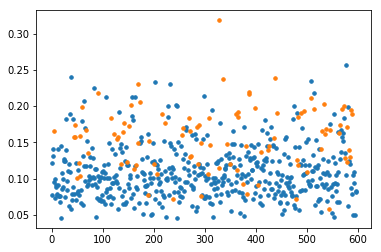

In [10]:
#plot error
groups=error_table.groupby('actual_class')
fig,ax=plt.subplots()
for name, group in groups:
    ax.plot(group.index,group.reconstruction_error,marker='o', ms=3.5, linestyle='',
            label= name)

![alt text](classes_scatter.png "reconstruction error for all instances in the training set")

The color on the plot identifies which data was indeed in the positive class. However, we aren't using that label in training, as this is unsupervised learning.

By coloring the points with their appropriate class we have shown that the autoencoder is able to predict which aircraft are spyplanes significantly better than chance (guessing randomly would only identify 15 spyplanes correctly on average).

In [11]:
# Applying the model to the unlabelled data

Now that we have a good degree of confidence that this approach can distinguish between normal aircraft and spyplanes, it's time to apply it to the whole dataset and see which aircraft are identified as most likely to be spyplanes:

![alt text](full_dataset_scatter.png "Title")

The higher the x value of a point, the more likely it is to represent a spyplane. Of course, we don't know how many spyplanes are in the dataset, so we can't pink a threshold value for the error. However, just for fun, I picked 0.2 as the threshold - it'd pretty arbritrary but above that we have only the most anomalous data points. So, I'm going to go ahead and say these points represent spyplanes. Let's get the identification numbers for those aircraft:

In [15]:

#get identifiers for predictes spyplanes
error_table['adshex']=df_adshex
positive_identifications=error_table[error_table['reconstruction_error']>=0.2]

That's 160 candidate aircraft identified. Let's see how many of the ones I identified were in common with the 101 identified by Peter Aldhous, the original author of the Buzzfeed News article:

In [16]:
#compare to previous results
pa_results=pd.read_csv("pa_candidates.csv")
common=set.intersection(set(positive_identifications['adshex']),set(pa_results['adshex']))

In [20]:
common

set()

Only 17 were in common with the previous results. This is not necessarily a bad thing since the two methods used completely different approaches. Both could be good classifiers, neither could be or one could be good and the other bad (or anything between these extremes). Without further data it is impossible to know.